In [4]:
## Good things to note about VAE models: 
## Dimensions of relevant quantities is worth keeping track of, so they don't have to be referenced
## independently.

## What is the best way to break up approximate posterior and generative model? 

## Abstractions: How abstracted out should the cost be/what is the best way to decompose the ELBO?

## For visualization/train testing purposes, how should we store and have restore function
## for weights? 

## When should we think about actually taking multiple samples of the Monte Carlo Expevtation? 

## For evaluation, we will always need our samples and parameters for our variational distributions, 

## Think about extracting out the reparametrization aspect, and making this feedable. 

## It's always something of a headache figuring out how to parametrize covariance matrices. Think
## about just abstracting this out once and forgetting about it in the future.

## It's easier to think about building the costs first, and then making the architectures in 
## such a way that these quantities are easy to recover.

## Come up with non-redundant naming schemes in order to distinguish different variables (important)
## when you have fifteen different means floating around.

import numpy as np
import tensorflow as tf
import matplotlib 
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

# Bayesian Mixture of Gaussians VAE
This notebook is an implementation of full Variational Inference in Variational Auto-Encoder. This is in contrast to typical implementations of VAEs in which the model implements variational inference over the local variational parameters, but performs MLE over the global variational parameters. This is a problem to the extent that it precludes comparisons between VAEs and more traditional VI methods (like CAVI) when considering how innovations like amortized inference influence inferred parameters. There is another interesting problem here, that describes the ways in which global parameters in the generative model can accomodate the variational family, that may be interesting to explore here by pre-training the generative model, and then freezing it with respect to approximate posterior performance. 

Our test case generative model will be a Bayesian Mixture of Gaussians: 

$\mu_{k} \sim \mathcal{N}(0,\sigma^{2}), k = 1\dots K$

$c_{i} \sim Cat(\frac{1}{K}\dots \frac{1}{K}), i = 1\dots N$

$x_{i}\vert c_{i}, \mu \sim \mathcal{N}(c_{i}^{T}\mu,1)$ 

Here $\sigma^{2}$ is a hyperparameter.

We will start by building network architectures that correspond to our generative model and approximate posterior. 

## Generative model
We start by building a generative model architecture that will allow us to draw samples, $x_i$ given inferred parameters $c_{i}$ and ${\mu_{k}}$. This generative model is very simple, and consists only of being able to perform an "inner product" to select out the appropriate means. Given that the $c_i$ variables are indexed by the data, they are mapped to activations. Given that the $\mu_{k}$ variables are global, we treat them as weights (but weights that are stochastic, and will be sampled from). The only thing that remains is to make sure that we can formulate our network in such a way that we can sample from our variational parameters in a way that will allow us to use the reparametrization trick. 

### Sampling Category Assignments: Gumbel-Softmax
In order to sample from the categorical distribution, we use the Gumbel-Softmax reparametrization (https://arxiv.org/pdf/1611.01144.pdf). 

In [5]:
## Specify number of categories: 
## Specify temperature (0 = Categorical)
## Specify categorical parameters 

def sample_gs(params,tau = 0.1):
    nb_cats = len(params)
    ## First sample from uniform:
    u_sample = np.random.uniform(0,1,nb_cats)
    ## Transform to gumbel sample
    g_sample = -np.log(-np.log(u_sample))
    ## Generate unnormalized potential
    potentials = np.exp((np.log(params)+g_sample)/tau)
    ## Partition Function
    Z = np.sum(potentials)
    return potentials/Z
    

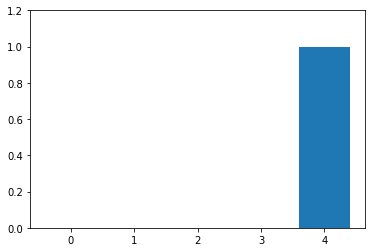

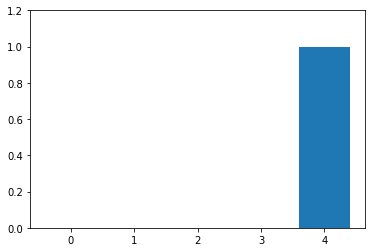

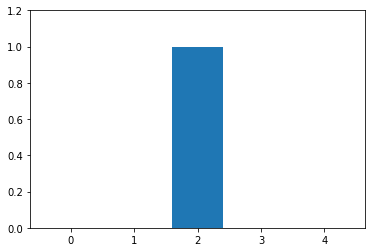

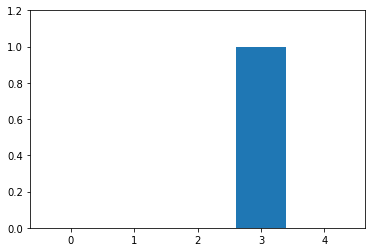

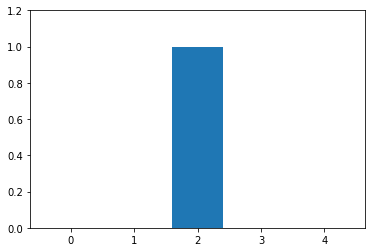

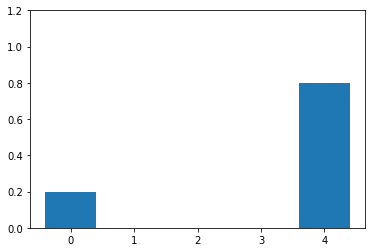

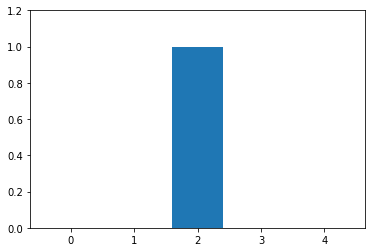

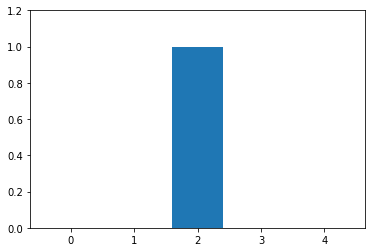

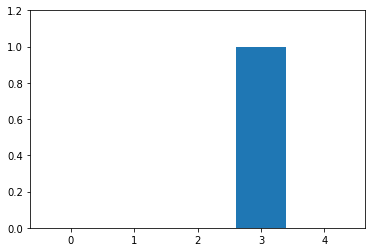

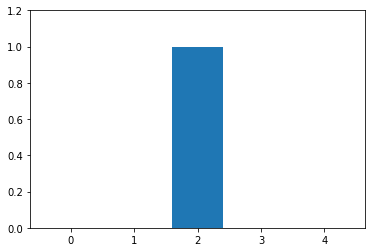

In [6]:
## Plot some samples:
params = np.array([0.2,0.2,0.2,0.2,0.2])
cats = len(params)
for i in range(10):
    s = sample_gs(params,tau = 0.04)
    plt.bar(np.linspace(0,cats-1,cats),s)
    plt.ylim(0,1.2)
    plt.show()

As $\tau$ is increased, samples will look more and more uniform. For purposes of differentiability, these samples will do. 

### Sampling Cluster Means: Gaussian
This is basically trivial: we use a location-scale reparametrization and don't worry about the rest. Parametrize the noise using an inverse square root transformation in order to generate efficient noise samples (multiply gaussian by inverse covariance matrix)

In [8]:
## Define the dimensionality of the space of Gaussians we use:
dim_z = 2
dim_eff = dim_z*cats

## Define the hyperparameter sigma_squared:

## Randomly sample means and inverse covariance square roots
means = np.random.normal(0,1,dim_eff)
## Not inverse wishart, but this is an illustration. Sample sqrt for stability.
a = np.random.random((dim_z, dim_z))

def sample_gauss(means,a,dim_z):
    dim_eff = len(means)
    cats = dim_eff/dim_z
    a *= np.tri(*a.shape)
    full = np.kron(np.eye(cats),a)
    uncorr = np.random.multivariate_normal(np.zeros(dim_eff),np.eye(dim_eff))
    corr_sample = (means + scipy.linalg.solve_triangular(full,uncorr,lower = True)).reshape(cats,dim_z)
    return corr_sample

### Sampling Data from Prior:
We can now sample from the prior by combining samples from the global and local variables, as follows:

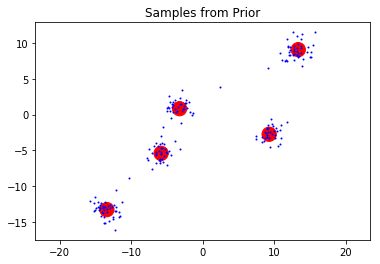

In [15]:
## Sample cluster means: 
inv_std = 0.1
mean_prior = np.zeros(dim_z*cats)
var_prior = np.eye(dim_z)*inv_std
mu_sample = sample_gauss(mean_prior,var_prior,dim_z)


## Choose number of datapoints to sample:
samples = 200
fig,ax = plt.subplots()
for mu in mu_sample:
    ax.plot(mu[0],mu[1],'ro')
    circle = plt.Circle((mu[0],mu[1]), 1, color='r')
    ax.add_artist(circle)
for sample in range(samples):
    ## Sample cluster assingment:
    cat_prior = np.array([0.2,0.2,0.2,0.2,0.2])
    c_sample = sample_gs(cat_prior,tau = 0.01)
    ## Sample data:
    mean = np.dot(c_sample,mu_sample)
    x_sample = np.random.multivariate_normal(mean,np.eye(dim_z))
    ax.plot(x_sample[0],x_sample[1],'bo',markersize = 1)
plt.axis('equal')
plt.title('Samples from Prior')
plt.show()

### Tensorflow implementation: Code Base

In [16]:
## Helper tensorflow function to construct a block diagonal matrix:
def block_diagonal(matrices, dtype=tf.float32):
    """Constructs block-diagonal matrices from a batch of 2D tensors.

    Args:
    matrices: A batch Tensor with shape [..., N_i, M_i]
    dtype: Data type to use. The Tensors in `matrices` must match this dtype.
    Returns:
    A matrix with the input matrices stacked along its main diagonal, having
    shape [..., \sum_i N_i, \sum_i M_i].

    """
    # This adapted function assumes that the tensors are all the same shape and batched as such.
    ## We need to first figure out what the first dimension of the arrays looks like:
    shape = tf.shape(matrices)
    nb_tensors = shape[0]
    implicit_dim = shape[1]
    indices = tf.range(nb_tensors)
    # indices = tf.constant([0,1,2,3,4,5,6,7,8,9])
    # We now design an iterable function that will produce "padded" versions of each array that can then
    # be added together with a reduce_sum operation.
    max_zeros = (nb_tensors)-1
    # this is ugly but okay
    # map_padded = lambda args: tf.random_normal([args[1]+15,5],mean = tf.cast(args[1],tf.float32),stddev = tf.cast(args[1],tf.float32),infer_shape = False)
    # map_padded = lambda args: (args[0]*tf.cast(args[1],tf.float32),args[1][0])

    # map_padded = lambda args: tf.pad(args[0],tf.Variable([[0,0],[args[1],max_zeros-args[1]]]))
    # map_padded = lambda args: tf.pad(args[0],tf.Variable([[tf.multiply(implicit_dim,args[1]),max_zeros-tf.multiply(implicit_dim,args[1])],[tf.multiply(implicit_dim,args[1]),max_zeros-tf.multiply(implicit_dim,args[1])]]))
    pad_matrix = lambda args : tf.concat((tf.concat((tf.tile(tf.zeros([implicit_dim,implicit_dim]),[1,args[0]]),args[1]),axis = 1),tf.tile(tf.zeros([implicit_dim,implicit_dim]),[1,max_zeros-args[0]])),axis=1) #= lambda index: tf.get_variable('padding',shape = (2,2),initializer = tf.constant_initializer([[0,0],[index,max_zeros-index]]))
    # block_diag = tf.map_fn(pad_calc,indices,dtype = tf.int32)

    block_diag = tf.reshape(tf.map_fn(pad_matrix,(indices,matrices),dtype = tf.float32),(nb_tensors*implicit_dim,nb_tensors*implicit_dim))

    return block_diag

## Sampling functions
## NOTE: We design our architecture to produce a single sample of sample means per minibatch of data. 
## It remains to be see how prohibitive to training this ends up being.
def sample_gaussian_tf(means,tri_params,sampleshape):
    ## We have [d,n(n+1)/2] triangular parameters for [d,n] dimensional means.
    ## These represent the elements of the cholesky decomposition of the inverse covariance matrix.
    mats = tf.contrib.distributions.fill_triangular(tri_params)
    ## Form into a block diagonal for easy correlated sample extraction:
    blk_cov_tri = block_diagonal(mats)
    ## Sample from the correlated matrix as s = C_inv_sqrt*eps, with eps uncorrelated
    corr_noise = tf.reshape(tf.matrix_triangular_solve(blk_cov_tri,tf.random_normal([tf.reduce_prod(means.shape),sampleshape[0]])),(sampleshape[0],means.shape[0],means.shape[1]))
    ## Repeat means to reflect samples:
    allmeans = tf.tile(tf.reshape(means,(1,means.shape[0],means.shape[1])),(sampleshape[0],1,1))
    
    ## We also want the full inverse covariance so we can evaluate mean sample probabilities under
    ## the global approximate posterior:
    full = tf.matmul(mats,mats,transpose_b = True)
    
    blk_cov = block_diagonal(full)
    return means+corr_noise,blk_cov

def sample_gs_tf(params,sampleshape,tau = 0.07):
    params = tf.cast(params,tf.float32)
    nb_cats = sampleshape[1]
    u_sample = tf.random_uniform(sampleshape)
    g_sample = -tf.log(-tf.log(u_sample))
    potentials = tf.exp((tf.log(params)+g_sample)/tau)
    Z = tf.reshape(tf.reduce_sum(potentials,axis = 1),(sampleshape[0],1))
    return potentials/Z

## Compute means of datapoints to be considered (this is most of our generative model)
def data_mean(params,means,tri_params):
    sampleshape = tf.shape(params)
    nb_cats = sampleshape[1]
    gauss_sample,blk_covars = sample_gaussian_tf(means,tri_params,sampleshape) ## Size [N,K,dim_gaussians]
    gumsoft_sample = tf.reshape(sample_gs_tf(params,sampleshape),(sampleshape[0],1,sampleshape[1])) ## Size [N,1,K]
    data_mean = tf.reshape(tf.matmul(gumsoft_sample,gauss_sample),(sampleshape[0],-1)) ## Size [N,dim_gaussians]

    return(data_mean,blk_covars)

### Tensorflow implementation: Testing

In [25]:
## Test Tensorflow implementation:
# Parameters: 
tf_catnumber = 5
nb_samples = 500
dim_z = 2
tf_params = np.tile(np.array([1./tf_catnumber for i in range(tf_catnumber)]).reshape(1,tf_catnumber),(nb_samples,1))

## Initialize tf random variables: These correspond to global variational parameters. 

tf_means = tf.random_normal((tf_catnumber,dim_z))*5
tf_trivars = tf.random_normal((tf_catnumber,dim_z*(dim_z+1)/2),2)

# Define Network Output:
tf_data_means,cov = data_mean(tf_params,tf_means,tf_trivars)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    out = sess.run([tf_data_means,tf_means,cov])
    sample_means,dist_means = out[0],out[1]


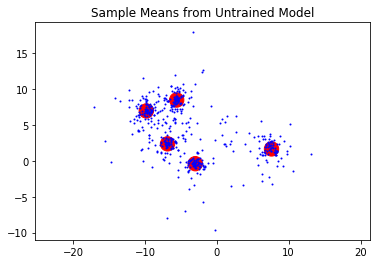

In [26]:
## Plot results:
fig,ax = plt.subplots()
for mu in dist_means:
    ax.plot(mu[0],mu[1],'ro')
    circle = plt.Circle((mu[0],mu[1]), 1, color='r')
    ax.add_artist(circle)
for sample in range(nb_samples):
    ax.plot(sample_means[sample,0],sample_means[sample,1],'bo',markersize = 1)
plt.axis('equal')
plt.title('Sample Means from Untrained Model')
plt.show()

## Approximate Posterior

What we normally call the approximate posterior in the context of orthodox VAEs here consists only of the approximate posterior for local latent variables. Note that for this particular model, we are not really "training" anything about the generative model; we are doing pure approximate inference on the local variational parameters in the encoder, (computed as activations) and approximate inference on the global variational parameters in the decoder (computed as weights). We do not build very much structure into our approximate posterior; we simply need a mechanism for computing the parameters of a categorical latent variable as a function of datapoints. This can be formulated as an MLP (why not two layers?) with softmax on the second layer. 

In [122]:
## Define layer by layer what is happening: 
data = tf.placeholder(tf.float32,shape = [None,nb_samples])

def approx_post(data):
    ## First layer: 
    nb_units = 100
    W1 = tf.Variable(tf.random_normal(shape=[nb_samples,nb_units],mean=0.,stddev=np.sqrt(2)/np.sqrt(nb_samples+nb_units)))
    b1 = tf.Variable(tf.zeros([1,nb_units]))
    L1 = tf.nn.sigmoid(tf.matmul(data,W1)+b1)

    ## Second layer:
    W2 = tf.Variable(tf.random_normal(shape=[nb_units,tf_catnumber],mean=0.,stddev=np.sqrt(2)/np.sqrt(tf_catnumber+nb_units)))
    b2 = tf.Variable(tf.zeros([1,tf_catnumber]))
    L2 = tf.nn.softmax(tf.matmul(L1,W2)+b2)

    ## Done! 
    return L2

## Cost Function:

We now want to write down our cost function, which will be the negative ELBO. This term can be computed by taking samples of the local and global variational parameters according to their current densities. In order to do this, we need to evaluate five different quantities: 

    1) Log Likelihood
    
    2) Log Prior on Local Variational Parameters
    
    3) Log Approximate Posterior on Local Variational Parameters
    
    4) Log Prior on Global Variational Parameters
    
    5) Log Approximate Posterior on Global Variational Parameters

### Log Likelihood

In [28]:
## This is easy: just the norm of the mean and the data residual. 
def llikelihood(data,means):
    dimension = tf.shape(means)[1]
    residual = data-means
    rms = -tf.reduce_sum(tf.square(residual),axis = 1)
    ## We don't have a covariance matrix to multiply by, because the data is distributed with unit 
    ## covariance. 
    ## We need a constant out front: 
    const = -dimension/2*np.log(2*np.pi)
    llcost = rms+const
    return llcost

### Log Prior (Local)

In [29]:
## We want to evaluate the log prior at the sample generated by our approximate posterior.
## Our prior is symmetric, so we just end up getting a constant term (assume our samples are)
## One hot- draws, or even proportions of the value that add up to one.
def lpriorloc(pvec):
    cats = tf.shape(pvec)[1]
    lprior = -np.log(cats)
    return lprior

### Log Approximate Posterior (Local)

In [30]:
## We want to now calculate the probability that our sample came from the approximate posterior
## on the categories, which is given by the relevant parameter. It's not clear to me if this
## approximate posterior should be evaluated as categorical samples, or gumbel-softmax samples.
def lapproxpostloc(pvec,lsamples):
    values = tf.log(tf.reduce_sum(tf.multiply(pvec,lsamples),axis = 1))
    return values

### Log Prior (Global)

In [31]:
## We now want to calculate the sample probability of the cluster means under the log prior. 
## This can be done by taking an inner product of the sampled means with itself (prior mean
## is 0), and multiplying by the hyperparameter representing the standard deviation of the prior.
def lpriorglob(std,gsamples):
    dimension = tf.shape(gsamples)[1]
    rms = -tf.reduce_sum(tf.square(gsamples),axis = 1)/std
    const = -dimension/2*np.log(2*np.pi*std)
    return rms+const

### Log Approximate Posterior (Global)

In [32]:
## Finally, calculate the sample probability of the cluster means under the approximate posterior. 
## This is the most expensive aspect of the cost, as we have to now take an inner product of samples
## minus means with itself, with norm given by the block covariance matrix.
def lapproxpostglob(blk_covars,means,samples):
    resid = (samples-means)
    dimension = tf.shape(means)[1]
    ## Multiply:
    transformed = tf.tensordot(blk_covars,resid,axes = [[2],[1]])
    ## And again: 
    resids = tf.tensordot(transformed,resid,axes = [[1],[1]])
    
    const = -dimension/2*tf.log(2*np.pi*tf.matrix_determinant(blk_covars))
    

### Assemble the Elbo!

In [ ]:
ELBO = 